In [1]:
import pandas as pd
import numpy as np
import os,glob
from matplotlib import pyplot as plt

Joey's code but modified to do any number of topics

# run a random forest on these words and see how well it can identify labels

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [4]:
glob.glob('third*.json')

['third_encoded_LDA_with_topics.json']

In [5]:
df = pd.read_json('third_encoded_LDA_with_topics.json')

In [6]:
#get the feature columns: those that start with 'key_word:'
feat = [x for x in df.columns if x[:9] == 'key_word:']
len(feat)

13272

# choose two topics to classify

In [16]:
topics = ['hope','home','missionary work']
sizes = []
for topic in topics:
    temp = df.loc[df[topic] == 1].shape[0]
    sizes.append(temp)
    print('the topic',topic,'has',temp,'talks associated')

the topic hope has 42 talks associated
the topic home has 77 talks associated
the topic missionary work has 145 talks associated


In [17]:
# make an even dataset
resized_dfs = []
for topic in topics:
    resized = df.loc[df[topic] == 1].iloc[:np.array(sizes).min()].copy()
    resized_dfs.append(resized)
    print(resized.shape[0], end=' ')
new = pd.concat(resized_dfs)

42 42 42 

In [18]:
new.shape

(126, 13583)

# are there any instances that are both topics

In [19]:
topic_sum = sum(new[topic] for topic in topics)
remove_ind = new[topic_sum > 1].index
if len(remove_ind) > 0:
    print(len(remove_ind))
    new.drop(index=remove_ind,inplace=True)

5


# reduce the feature to where only these talks have these words so there is a one in each column

In [20]:
# get all the features 
b = new
all_key_words = set()
for i in range(b.shape[0]):
    all_key_words = all_key_words.union(set(b.iloc[i]['words']))
new_feat = ['key_word:' + word for word in all_key_words]
print(len(new_feat))

3402


# PREDICT WHETHER THE TALK IS HOME

# test train split

In [21]:
X = new[new_feat].copy()
print('the target variable is:',topics[0])
y = sum(new[topic]*i for i, topic in enumerate(topics)) #new[topics[0]]
print(y) #I think this is right
print('X.shape',X.shape)

the target variable is: hope
79     0
107    0
108    0
114    0
177    0
      ..
446    2
451    2
459    2
461    2
462    2
Length: 121, dtype: int64
X.shape (121, 3402)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)


In [23]:
for obj in [X_train, X_test, y_train, y_test]:
    print(obj.shape)

(108, 3402)
(13, 3402)
(108,)
(13,)


In [55]:
# X_train

# RUN THE MODEL 

In [60]:
clf = RandomForestClassifier(n_estimators=10
                             ,n_jobs=-1
                             ,oob_score=True)
clf = clf.fit(X_train, y_train)
clf.score(X_train, y_train)

1.0

In [25]:
#mean accuracy
clf.score(X_test,y_test)

0.8461538461538461

In [26]:
clf.predict_proba(X_test)

array([[0.9, 0. , 0.1],
       [0.1, 0.6, 0.3],
       [0.2, 0.6, 0.2],
       [0.6, 0.4, 0. ],
       [0.5, 0.3, 0.2],
       [0.3, 0. , 0.7],
       [0. , 0.3, 0.7],
       [0.5, 0.5, 0. ],
       [0.3, 0.6, 0.1],
       [0.3, 0.3, 0.4],
       [0.3, 0.2, 0.5],
       [0.6, 0.3, 0.1],
       [0.5, 0.4, 0.1]])

# IF IT'S STRUGGLING THEN TRY NORMALIZING FEATURES

In [50]:
importances = pd.Series({new_feat[i].replace('key_word:',''):importance for i, importance in enumerate(clf.feature_importances_) if importance > 0})
importances.sort_values(inplace=True, ascending=False)
importances[:20]

home            0.038786
missionaries    0.029303
christ          0.020646
missionary      0.020048
members         0.018442
life            0.017892
work            0.017500
men             0.015140
temple          0.013320
families        0.012994
family          0.012372
god             0.012034
make            0.011548
words           0.011533
hope            0.010915
spirit          0.010834
covenants       0.010519
stake           0.010134
including       0.009927
jesus           0.009925
dtype: float64

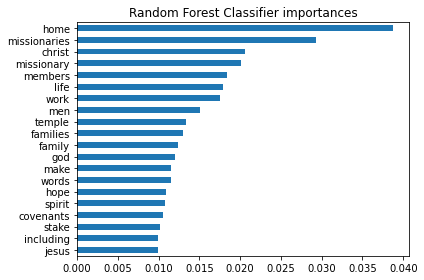

In [59]:
importances[19::-1].plot(kind='barh')
plt.title("Random Forest Classifier importances")
plt.tight_layout()
plt.savefig("rfc_importances.png", dpi=128)
plt.show()